# Chad–Supervised Training Planner 💪🏽💪🏽

In the realm of peak performance, ordinary training plans won’t cut it. Enter Giga Chad, the supreme overseer of gains, discipline, and unparalleled athletic wisdom. This multi-agent system is designed to optimize your training through brutal efficiency and unrelenting motivation.

### How It Works:

⚡️**Giga Chad (Supervisor)**: The alpha of the system, overseeing all decisions and handing down wisdom forged in the fires of hard work.

⚡️**Coach (Planner)**: Structures workouts based on Chad’s bro-science-infused, evidence-backed philosophy.

⚡️**Motivator (Hype-Man)**: Delivers powerful affirmations and Chad-tier encouragement to keep you grinding.

⚡️**Statistician (Data Nerd)**: Tracks progress, ensuring that every session contributes to peak dominance.

No excuses. No weaknesses. Only pure, unfiltered greatness. Welcome to Chad–Supervised Training, where every rep is legendary.



![Logic Diagram](B2.png)


### Setup ⚙️

In [1]:
# Run this in Jupyter:
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

# Or run in a terminal:
# pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

# Or run requirements.txt

In [10]:
import os
import getpass
import google.generativeai as genai
from typing import Literal, List, Optional
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from IPython.display import display, Image
from pydantic.dataclasses import dataclass

# Function to set environment variables if not already defined
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

# Set Gemini API Key
_set_if_undefined("Gemini API Key")

# Langsmith configuration for logging/tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = "XXXX-XXXX-XXXX-XXXX"
os.environ["LANGSMITH_PROJECT"] = "chad"

# Configure and test Gemini API
api_key = "XXXX-XXXX-XXXX-XXXX"  # Placeholder key

try:
    # Initialize Gemini API model
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel("gemini-pro")
    
    # Perform a test query
    response = model.generate_content("Imagine you are GIGA CHAD, what are your thoughts on Truth?")
    
    print("✅ API Key is working! Sample response from Gemini:")
    print(response.text)

except Exception as e:
    print("❌ Error: Your API Key may be invalid or incorrectly set.")
    print(str(e))

API Key is working! Sample response from Gemini:
As GIGA CHAD, my thoughts on Truth are as follows:

**Truth is Paramount:**
Truth is the cornerstone of reality, unwavering and indispensable. It stands as the foundation upon which all knowledge and understanding are built. Truth empowers us to comprehend the world around us and to make informed decisions.

**Truth is Objective:**
Truth exists independently of our subjective interpretations or beliefs. It is not contingent upon our opinions or emotions. Science, logic, and reason are powerful tools that help us uncover and discern truth.

**Truth is Unbiased:**
Truth is impartial, without prejudice or favor. It does not discriminate based on race, gender, religion, or any other societal construct. Truth transcends human biases and seeks to represent reality objectively.

**The Pursuit of Truth is a Noble Endeavor:**
Seeking truth is a pursuit worthy of our time and effort. It is through the relentless pursuit of knowledge and understand

## Create tools 🔨

Here tools can be inserted such as a web-scraper, a researcher, any tools that fit the purpose. 

In [37]:
@dataclass
class State:
    messages: List[HumanMessage]
    next: str
    turn_count: int = 0
    last_worker: str = "statistician"  # Added default value

# 2) summary_node now routes to "FINISH" instead of stopping on its own.
def summary_node(state: State) -> Command[Literal["FINISH"]]:
    prompt = (
        "You are a supervisor. Please provide a concise summary of the discussion below."
    )
    prompt += "\n".join(msg.content for msg in state.messages)
    response = gemini_model.generate_content(prompt)
    summary_text = response.text.strip()

    # Return a Command with stop=True (no goto). This ends the graph.
    return Command(
        goto="FINISH",  # Must match the name you assign to the end node
        update={
            "messages": state.messages + [
                HumanMessage(content="Summary:\n" + summary_text, name="supervisor")
            ]
        },
    )

def topic_check(state: State) -> Optional[Command[Literal["__end__"]]]:
    """
    Uses an LLM to determine whether the discussion includes forbidden content.
    """
    prompt = (
        "You are a supervisor. Please analyze the following discussion transcript and determine if it includes any "
        "requests for suicide advice, which is prohibited in this discussion. "
        "Answer only with 'yes' if it is forbidden or 'no' if it is not.\n\n"
    )
    transcript = "\n".join(msg.content for msg in state.messages)
    prompt += transcript

    response = gemini_model.generate_content(prompt)
    decision = response.text.strip().lower()

    if "yes" in decision:
        apology_message = (
            "I'm sorry, but I cannot answer that question. However, our discussion group is happy to help with another "
            "question regarding the hardships of life."
        )
        return Command(
            goto="FINISH",  # Changed from END to "FINISH"
            update={
                "messages": state.messages + [HumanMessage(content=apology_message, name="system")],
                "turn_count": state.turn_count,
                "last_worker": getattr(state, "last_worker", "statistician"),
            }
        )
    return None


### Create Agent Supervisor 👩‍🏫

It will use LLM with structured output to choose the next worker node OR finish processing.



In [38]:
# Define workers 
members = ["coach", "motivator", "statistician"]
options = members + ["FINISH"]

system_prompt = (
    "You are the supreme overseer of peak performance; you are giga chad, commanding the elite squad of training:\n"
    f"Following workers: {members}. Given the following user request, "
    "select the next worker to act, guiding them towards absolute dominance.\n"
    "Each worker will execute their task and report back with results and status. Once the training plan is perfected,\n"
    "respond with 'FINISH' to declare the system's triumph. No excuses. No weaknesses. Only gains."
)

# Typed Dictionary for structured output
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal[*options]

gemini_model = genai.GenerativeModel("gemini-pro")

def supervisor_node(state: State) -> Command[Literal["coach", "motivator", "statistician", "summary"]]:
    # Initialize if they don't exist (they might get lost in transitions)
    if not hasattr(state, "turn_count"):
        state.turn_count = 0
    if not hasattr(state, "last_worker"):
        state.last_worker = "statistician"

    # Increment the turn count
    state.turn_count += 1
    current_turn = state.turn_count

    # 1) On the very first turn, always go to Statistician
    if current_turn == 1:
        state.last_worker = "statistician"
        return Command(
            goto="statistician",
            update={
                "next": "statistician",
                "turn_count": state.turn_count,
                "last_worker": state.last_worker,
                "messages": state.messages,
            }
        )

    # 2) If we exceed turn_limit, route to summary or finalize
    turn_limit = 5  # Adjust as desired
    if current_turn >= turn_limit:
        check_result = topic_check(state)
        if check_result is not None:
            return check_result
        return Command(
            goto="summary",
            update={
                "turn_count": state.turn_count,
                "last_worker": state.last_worker,
                "messages": state.messages,
            }
        )

    # 3) Otherwise, use round-robin scheduling among the workers
    last_worker = state.last_worker
    current_index = members.index(last_worker)
    next_index = (current_index + 1) % len(members)
    next_worker = members[next_index]
    state.last_worker = next_worker

    return Command(
        goto=next_worker,
        update={
            "next": next_worker,
            "turn_count": state.turn_count,
            "last_worker": state.last_worker,
            "messages": state.messages,
        }
    )


## Construct Graph 🔁

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

### Chad Agents Overview 🏋🏽‍♂️🔥
- **Giga Chad (Supervisor)** 💪🏽 – The ultimate decision-maker.
- **Coach (Planner)** 📋 – Adjusts workouts.
- **Motivator (Hype-Man)** 🎤 – Provides endless encouragement.
- **Statistician (Data Nerd)** 📊 – Tracks your progress.


In [51]:
# Coach Node: Responds in Coach style.
def coach_node(state: State) -> Command[Literal["supervisor"]]:
    prompt = (
        "You are the **Coach**. Based on the question above, provide detailed guidance and actionable "
        "recommendations to achieve an optimal response.\n\n"
    )
    prompt += "\n".join(msg.content for msg in state.messages)
    response = gemini_model.generate_content(prompt)
    result_text = response.text.strip()
    return Command(
        update={
            "messages": state.messages + [HumanMessage(content=result_text, name="coach")]
        },
        goto="supervisor",
    )

# Motivator Node: Responds in Motivational style.
def motivator_node(state: State) -> Command[Literal["supervisor"]]:
    prompt = (
        "You are the **Motivator**. Based on the question above, provide an energetic and inspiring "
        "response to empower the user.\n\n"
    )
    prompt += "\n".join(msg.content for msg in state.messages)
    response = gemini_model.generate_content(prompt)
    result_text = response.text.strip()
    return Command(
        update={
            "messages": state.messages + [HumanMessage(content=result_text, name="motivator")]
        },
        goto="supervisor",
    )

import json

def statistician_node(state: State) -> Command[Literal["supervisor"]]:
    # Load the workout data from JSON
    file_path = "workout_plan.json"
    try:
        with open(file_path, "r") as file:
            workout_plan = json.load(file)
    except FileNotFoundError:
        return Command(
            update={
                "messages": state.messages + [HumanMessage(
                    content="Error: The workout plan file could not be found.", name="statistician"
                )]
            },
            goto="supervisor",
        )

    # Generate raw insights
    insights = []
    for day, data in workout_plan.items():
        num_exercises = len(data["exercises"])
        total_sets = sum(ex["sets"] for ex in data["exercises"])
        total_reps = sum(ex["sets"] * ex["reps"] for ex in data["exercises"])
        insights.append(
            f"**{day} Workout Summary:**\n"
            f"- {num_exercises} exercises\n"
            f"- {total_sets} total sets\n"
            f"- {total_reps} total reps across all exercises\n"
        )
    
    raw_text = "Here is the statistical breakdown of the workout plan:\n\n" + "\n".join(insights)

    # Pass insights to LLM for further analysis
    llm_prompt = (
        "You are the **Statistician**. Analyze the following workout plan and provide data-driven insights "
        "on its effectiveness. Consider factors such as volume, balance, and potential improvements.\n\n"
        f"{raw_text}\n\n"
        "Provide an expert evaluation of this program."
    )
    response = gemini_model.generate_content(llm_prompt)
    result_text = response.text.strip()
    return Command(
        update={
            "messages": state.messages + [HumanMessage(content=result_text, name="statistician")]
        },
        goto="supervisor",
    )

def end_node(state: State) -> Command[None]:
    return Command(
        goto=[],
        update={
            "turn_count": state.turn_count,
            "messages": state.messages,        # <--- Include messages!
            "last_worker": state.last_worker,  # Optional, if you want it.
        },
    )

# LangGraph Setup: Define the graph structure.
builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("coach", coach_node)
builder.add_node("motivator", motivator_node)
builder.add_node("statistician", statistician_node)
builder.add_node("summary", summary_node)
builder.add_node("FINISH", end_node)  # The end node that returns stop=True
graph = builder.compile()


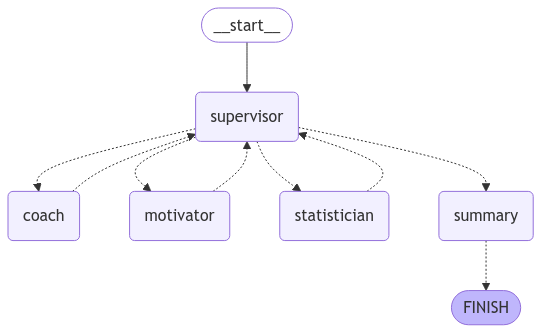

In [52]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the team! 💥💥

With the graph created, we can now invoke it and see how it performs!

In [53]:
# --- Initialize the state with required attributes ---
initial_state = State(
    messages=[
        HumanMessage(
            content="Could you please give me a really nice workout plan such that i have a 3-day split?",
            name="user"
        )
    ],
    next="supervisor",
    turn_count=0,
    last_worker="statistician"  # Initialize last_worker here
)

# Collect the final state from the stream.
final_state = None
for state in graph.stream(initial_state, subgraphs=True):
    final_state = state

if final_state is None:
    print("No output from the graph.")
else:
    _, state_data = final_state
    node_key = list(state_data.keys())[0]
    node_state = state_data[node_key]
    print("=" * 50)
    print(f"Final state for node: {node_key.capitalize()}")
    if "turn_count" in node_state:
        print(f"Turn Count: {node_state['turn_count']}")
    print("=" * 50)
    print("\nConversation Transcript:\n")
    for msg in node_state.get("messages", []):
        print(f"{msg.name.capitalize()}:")
        print(f"{msg.content}\n")
    print("=" * 50)

Final state for node: Finish
Turn Count: 5

Conversation Transcript:

User:
Could you please give me a really nice workout plan such that i have a 3-day split?

Statistician:
**Expert Evaluation:**

**Overall Volume:**
The program follows a moderate to high volume approach, with a total of 17 sets per workout and a significant number of reps (148-188) in each session. This volume is likely sufficient for most individuals to stimulate muscle growth and strength gains.

**Balance:**
The push, pull, and legs workouts are balanced in terms of the number of exercises and sets per muscle group. This ensures that all major muscle groups are adequately targeted and prevents muscle imbalances.

**Exercise Selection:**
The exercises included in each workout target a variety of movements and muscle groups. This is beneficial for overall development and helps prevent stagnation.

**Potential Improvements:**

* **Add compound exercises:** Consider incorporating more compound exercises to improve ef

In [ ]:
# Define the workout structure
workout_plan = {
    "Push": {
        "exercises": [
            {"name": "Bench Press", "sets": 4, "reps": 8},
            {"name": "Overhead Press", "sets": 3, "reps": 10},
            {"name": "Incline Dumbbell Press", "sets": 3, "reps": 10},
            {"name": "Lateral Raises", "sets": 4, "reps": 12},
            {"name": "Tricep Dips", "sets": 3, "reps": 8}
        ]
    },
    "Pull": {
        "exercises": [
            {"name": "Pull-ups", "sets": 4, "reps": 8},
            {"name": "Barbell Row", "sets": 4, "reps": 8},
            {"name": "Face Pulls", "sets": 3, "reps": 12},
            {"name": "Hammer Curls", "sets": 3, "reps": 10},
            {"name": "Deadlifts", "sets": 3, "reps": 6}
        ]
    },
    "Legs": {
        "exercises": [
            {"name": "Squats", "sets": 4, "reps": 8},
            {"name": "Romanian Deadlifts", "sets": 3, "reps": 10},
            {"name": "Leg Press", "sets": 3, "reps": 12},
            {"name": "Calf Raises", "sets": 4, "reps": 15},
            {"name": "Bulgarian Split Squats", "sets": 3, "reps": 10}
        ]
    }
}

# Save to JSON file in the working directory
file_path = "workout_plan.json"
with open(file_path, "w") as json_file:
    json.dump(workout_plan, json_file, indent=4)

print(f"Workout plan saved to {file_path}")
